<a href="https://colab.research.google.com/github/Recommendation-System-Project/Recommendation-system/blob/main/DR_coat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

In [2]:
import pandas as pd
import numpy as np 

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

## Imputation Error

In [3]:
def loss_emputation(w,y,r,e,p):
  return  ((w*r)**2 - 2*w*y*r + y**2 - e)**2/p

def gradient_descent(w, y, le, observed_e, predicted_r, propensities, max_iter, lr=0.0001):
  w.requires_grad = True
  y.requires_grad = True
  m = observed_e.shape[0]
  theta = [w.item(), y.item()]
  iter_list = []
  loss_list = []
  for i in range(max_iter):
    loss = 0
    rand1 = np.random.randint(0, m, 1)
    r = torch.from_numpy(predicted_r[rand1]).type(torch.float32)
    e = torch.from_numpy(observed_e[rand1]).type(torch.float32)
    p = torch.from_numpy(propensities[rand1]).type(torch.float32)

    output = le(w,y,r,e,p)
    output.backward()
    w.data -= lr * w.grad
    y.data -= lr * y.grad
    w.grad.fill_(0)
    y.grad.fill_(0)

    # for j in range(m):
    #   every_loss = le(w,y,predicted_r[j],observed_e[j],propensities[j]).item()
    #   loss = loss + every_loss
    theta[0] = w.item()
    theta[1] = y.item()
    # print("iter_count: ", i, "the loss: ",loss)
    # print("theta:", theta)
    # iter_list.append(i)
    # loss_list.append(loss)
      
  # plt.plot(iter_list, loss_list)
  # plt.xlabel("iter")
  # plt.ylabel("loss")
  # plt.show()
  # return theta, loss
  for j in range(m):
      every_loss = le(theta[0],theta[1],predicted_r[j],observed_e[j],propensities[j]).item()
      loss = loss + every_loss
  return theta, loss

## Factorization Machine

In [4]:
# FM 特征组合层
class crossLayer(layers.Layer):
    def __init__(self,input_dim, output_dim=10, **kwargs):
        super(crossLayer, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        # 定义交叉特征的权重
        self.kernel = self.add_weight(name='kernel', shape=(self.input_dim, self.output_dim), initializer='glorot_uniform',trainable=True)
        
    def call(self, x): # 对照上述公式中的二次项优化公式一起理解
        a = K.pow(K.dot(x, self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return 0.5 * K.mean(a-b, 1, keepdims=True)

# 定义FM模型
def FM(feature_dim, e, p, O_mask):
    inputs = Input(shape=(feature_dim, ))
    
    # 一阶特征
    linear = Dense(units=1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(inputs)
    
    # 二阶特征
    cross = crossLayer(feature_dim)(inputs)
    add = Add()([linear, cross])  # 将一阶特征与二阶特征相加构建FM模型
    
    # pred = add
    pred = Activation('sigmoid')(add)
    model = Model(inputs=inputs, outputs=pred)
    
    # model.summary()

    # 以下两段loss定义格式不应更改，keras的loss有且仅有两个参数y_true, y_pred
    def my_coef(y_true, y_pred, predicted_e, propensities, mask):
      error = tf.square(y_true - y_pred)
      error = tf.reshape(error, [290, 300])
      delta = tf.subtract(error, predicted_e)
      a = tf.multiply(mask, delta)
      b = tf.divide(a, propensities)
      return tf.add(predicted_e, b)

    def my_loss_fn(predicted_e, propensities, mask):
      def loss(y_true, y_pred):
        return my_coef(y_true, y_pred, predicted_e, propensities, mask)
      return loss
      
    model.compile(loss=my_loss_fn(predicted_e = e, propensities = p, mask = O_mask),
                  optimizer=optimizers.SGD(), metrics=['accuracy'])

    
    return model    

## Graphic Result

In [5]:
def result(history):
  # list all data in history
  print(history.history.keys())
  print("Test accuracy: ", history.history['val_accuracy'][-1])
  print("Test loss: ", history.history['val_loss'][-1])
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Preparing Data

In [6]:
def get_data():
  observed_r = np.genfromtxt("data/train.ascii", dtype=None) # observed ratings
  observed_r = observed_r.astype('float')
  observed_r[observed_r == 0] = np.nan
    
  predicted_r = np.random.randint(1,5,size=observed_r.shape) # predicted rating
    
  propensities = np.genfromtxt("data/our_propensities.ascii", dtype=None) # propensities for all user item pairs

  O_mask = np.int64(observed_r != np.nan)

  item_features = np.genfromtxt("data/item_features_encoded.ascii", dtype=None)
  user_features = np.genfromtxt("data/user_features.ascii", dtype=None)

  test_r = np.genfromtxt("data/test.ascii", dtype=None) # observed ratings for test
  test_r = observed_r.astype('float')
   
  return observed_r, predicted_r, propensities, O_mask, item_features, user_features

In [7]:
def get_features_matrix(O_mask, user_features, item_features):
  features_matrix = []
  for u in range(O_mask.shape[0]):
    for i in range(O_mask.shape[1]):
      user_f = user_features[u]
      item_f = item_features[i]
      observed = np.concatenate((user_f, item_f))
      features_matrix.append(observed)
  features_matrix = np.array(features_matrix)
  return features_matrix

## Joint Learning

The time of execution Imputation: 0.5234956741333008
theta for imputation error:  [-0.13874375820159912, -0.42015624046325684]
loss for imputation error:  280552.37992227054

The time of execution FM: 14.908798933029175
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9465632438659668
Test loss:  22.331022262573242


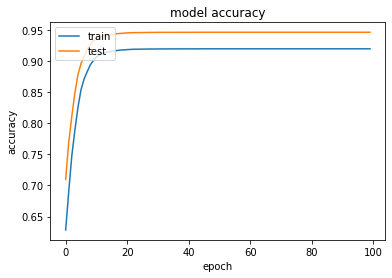

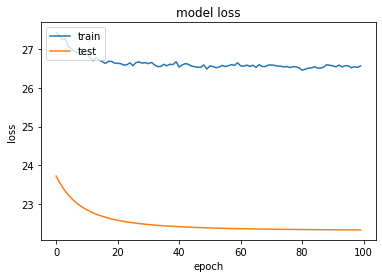

The time of execution Imputation: 0.4104645252227783
theta for imputation error:  [-1.2383661270141602, -0.24241861701011658]
loss for imputation error:  717559.5501799879

The time of execution FM: 9.364948034286499
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.945678174495697
Test loss:  7.921843528747559


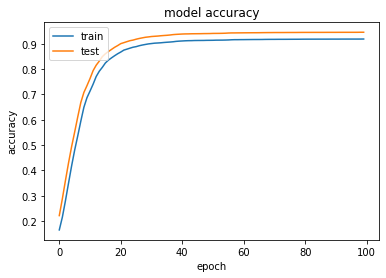

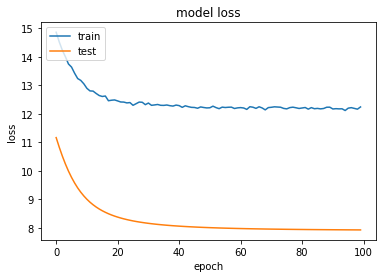

The time of execution Imputation: 0.4270930290222168
theta for imputation error:  [0.31945738196372986, 0.062433838844299316]
loss for imputation error:  721534.799740743

The time of execution FM: 9.48206639289856
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9463908076286316
Test loss:  4.615577220916748


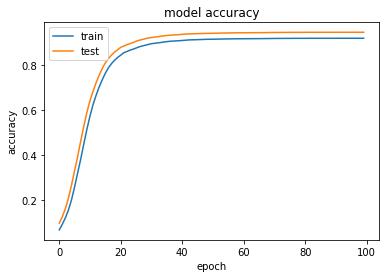

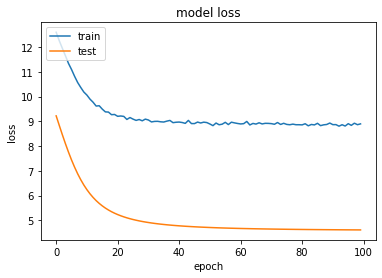

The time of execution Imputation: 0.42082881927490234
theta for imputation error:  [0.697633683681488, 0.1639038324356079]
loss for imputation error:  723989.1154937837

The time of execution FM: 14.383178472518921
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9451034665107727
Test loss:  4.637526512145996


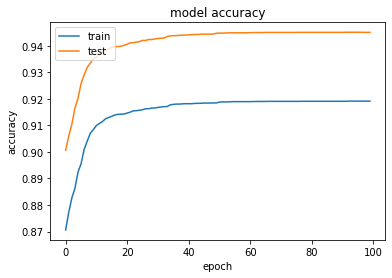

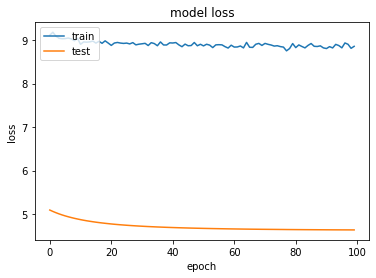

The time of execution Imputation: 0.40742945671081543
theta for imputation error:  [0.15016119182109833, 0.021889343857765198]
loss for imputation error:  717013.6607095577

The time of execution FM: 9.310352802276611
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9448620676994324
Test loss:  4.634340286254883


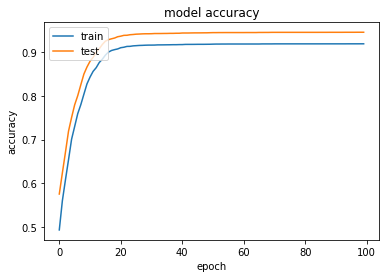

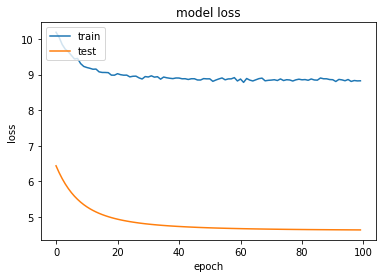

The time of execution Imputation: 0.40222883224487305
theta for imputation error:  [-0.32108721137046814, -0.07326217740774155]
loss for imputation error:  717498.162634317

The time of execution FM: 10.832786798477173
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9466666579246521
Test loss:  5.0042314529418945


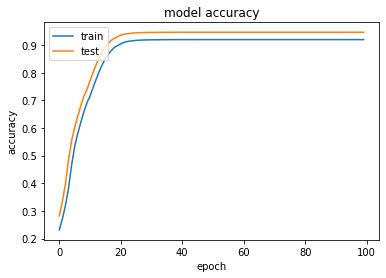

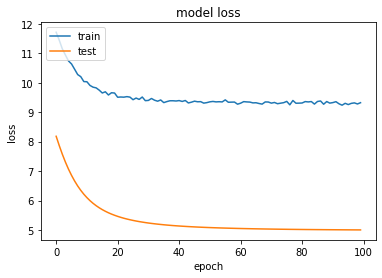

The time of execution Imputation: 0.4208862781524658
theta for imputation error:  [-1.1831914186477661, -0.2428349405527115]
loss for imputation error:  729718.1524798849

The time of execution FM: 10.720523595809937
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9455517530441284
Test loss:  7.6966328620910645


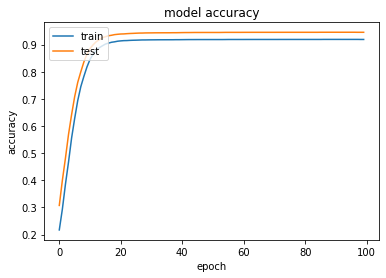

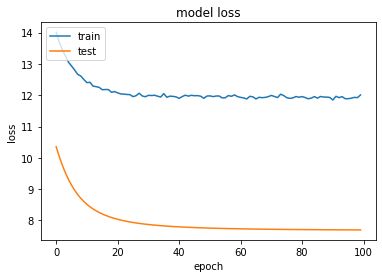

The time of execution Imputation: 0.43914365768432617
theta for imputation error:  [0.07448921352624893, 0.017662731930613518]
loss for imputation error:  716690.4091617811

The time of execution FM: 14.44596815109253
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9466666579246521
Test loss:  4.657528400421143


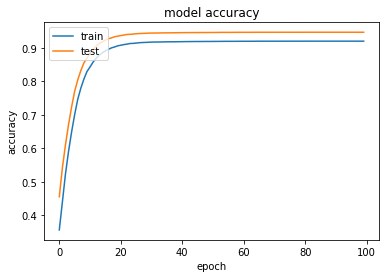

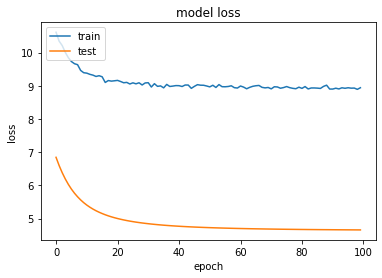

The time of execution Imputation: 0.41103672981262207
theta for imputation error:  [-1.7017762660980225, -0.3267451524734497]
loss for imputation error:  727416.4896456992

The time of execution FM: 15.958499431610107
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9461954236030579
Test loss:  10.861218452453613


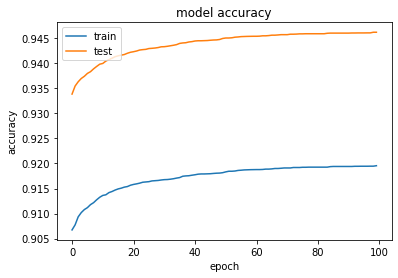

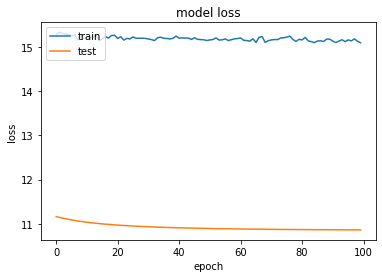

The time of execution Imputation: 0.4268617630004883
theta for imputation error:  [-2.4595839977264404, -0.464140385389328]
loss for imputation error:  732522.7431655072

The time of execution FM: 10.83261513710022
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9466666579246521
Test loss:  18.697086334228516


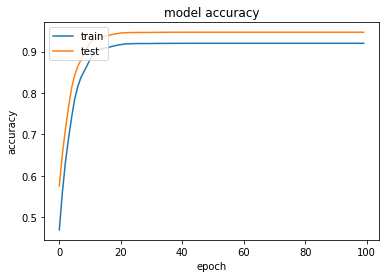

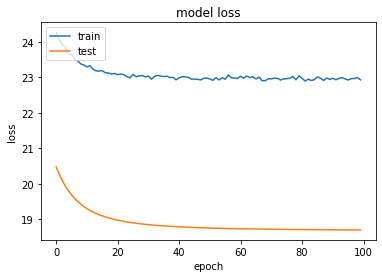

The time of execution Imputation: 0.42697978019714355
theta for imputation error:  [0.7574767470359802, 0.1487298160791397]
loss for imputation error:  720575.6059820373

The time of execution FM: 10.834936380386353
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9466207027435303
Test loss:  4.636828422546387


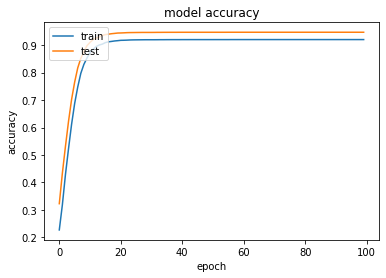

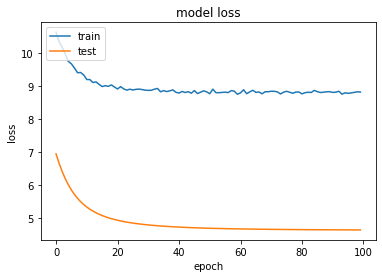

The time of execution Imputation: 0.40395545959472656
theta for imputation error:  [0.3410426080226898, 0.07492489367723465]
loss for imputation error:  709132.0801882091

The time of execution FM: 10.82973599433899
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9466666579246521
Test loss:  4.589601039886475


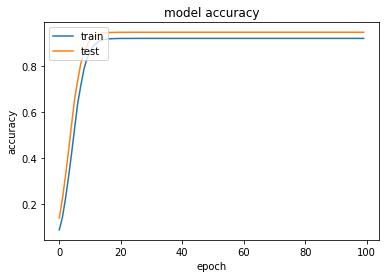

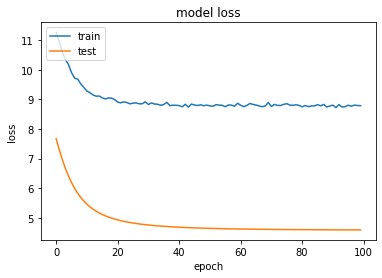

The time of execution Imputation: 0.43076300621032715
theta for imputation error:  [0.15461288392543793, 0.029598748311400414]
loss for imputation error:  710979.4543949864

The time of execution FM: 14.560544490814209
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9452758431434631
Test loss:  4.625237464904785


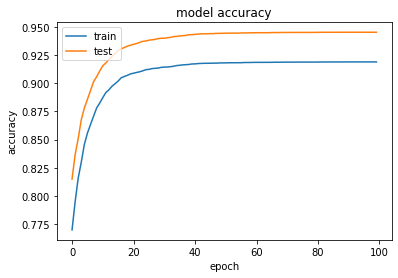

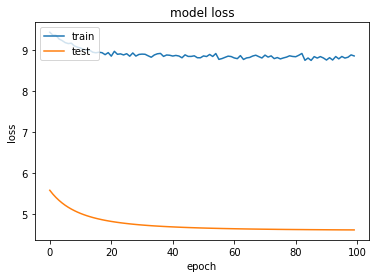

The time of execution Imputation: 0.4363429546356201
theta for imputation error:  [0.5879390835762024, 0.13465343415737152]
loss for imputation error:  714052.5778568937

The time of execution FM: 14.475033283233643
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9434137940406799
Test loss:  4.627572536468506


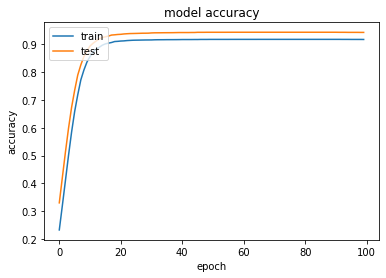

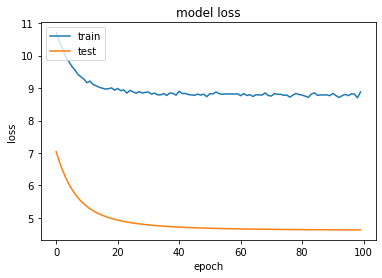

The time of execution Imputation: 0.41529011726379395
theta for imputation error:  [0.24717998504638672, 0.04359673708677292]
loss for imputation error:  709065.0332451473

The time of execution FM: 11.217234134674072
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9457471370697021
Test loss:  4.608952522277832


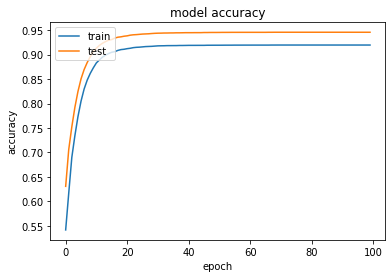

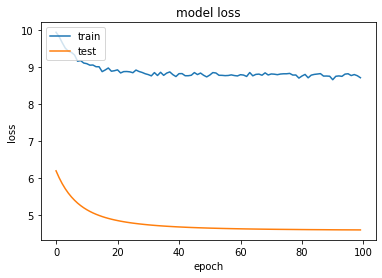

The time of execution Imputation: 0.43299269676208496
theta for imputation error:  [-0.5784229040145874, -0.10489949584007263]
loss for imputation error:  711152.1270825869

The time of execution FM: 9.52743935585022
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9466666579246521
Test loss:  5.400821685791016


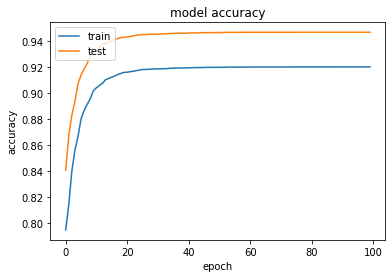

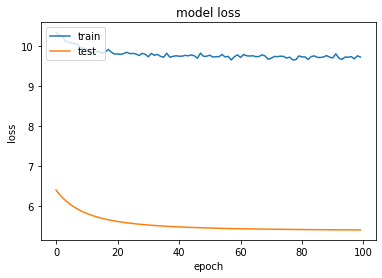

The time of execution Imputation: 0.43944406509399414
theta for imputation error:  [0.1814979761838913, 0.03872254490852356]
loss for imputation error:  727715.7120652233

The time of execution FM: 9.608154296875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9454367756843567
Test loss:  4.624305725097656


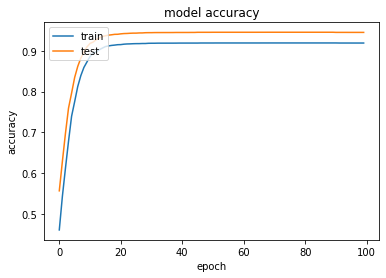

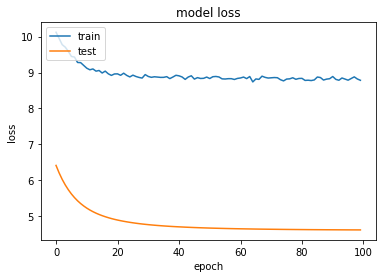

The time of execution Imputation: 0.438335657119751
theta for imputation error:  [-1.4051412343978882, -0.27748867869377136]
loss for imputation error:  715237.8332374123

The time of execution FM: 15.950528860092163
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9431723952293396
Test loss:  8.932512283325195


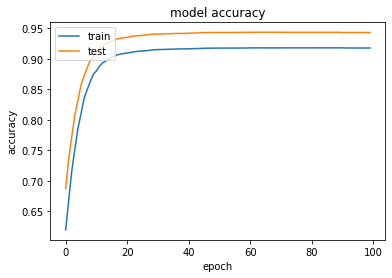

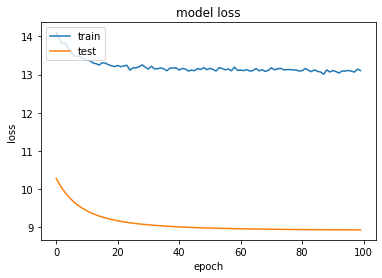

The time of execution Imputation: 0.4369394779205322
theta for imputation error:  [1.4404817819595337, 0.3068743050098419]
loss for imputation error:  713944.7918593175

The time of execution FM: 9.5977942943573
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9458160996437073
Test loss:  4.420433044433594


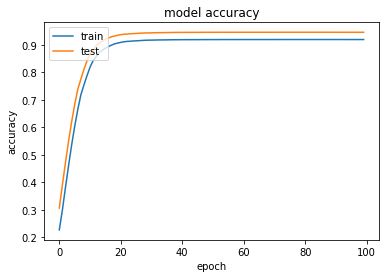

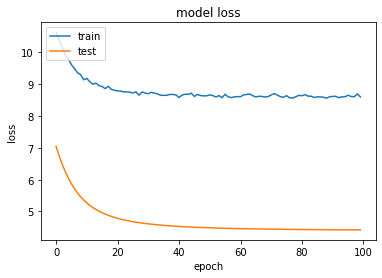

The time of execution Imputation: 0.4624307155609131
theta for imputation error:  [-0.3035249710083008, -0.06107284873723984]
loss for imputation error:  714078.4975070657

The time of execution FM: 15.982695817947388
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test accuracy:  0.9463562965393066
Test loss:  4.9802327156066895


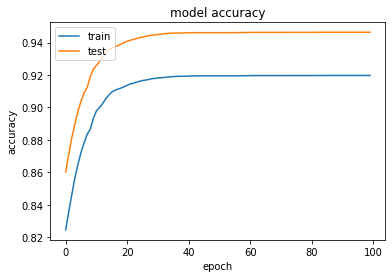

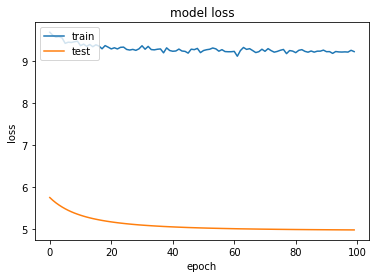

In [8]:
observed_r, predicted_r, propensities, O_mask, item_features, user_features = get_data()
features_matrix = get_features_matrix(O_mask, user_features, item_features)

observed_r_1d = observed_r.flatten()
observed_r_1d = observed_r_1d[~np.isnan(observed_r_1d)]
propensities_1d = np.array(propensities*O_mask).flatten()
propensities_1d = propensities_1d[propensities_1d != 0]
predicted_r_1d = np.array(predicted_r*O_mask).flatten()
predicted_r_1d = predicted_r_1d[predicted_r_1d != 0]

ratings_train = np.genfromtxt("data/train.ascii", dtype=None).astype(np.float32)
ratings_test = np.genfromtxt("data/test.ascii", dtype=None).astype(np.float32)
test_accuracy = 0.5

iter_count = 0
max_iter_joint = 20
while test_accuracy <= 0.95 and iter_count < max_iter_joint:
  observed_e = predicted_r - observed_r # e_ui
  observed_e_1d = observed_e.flatten()
  observed_e_1d = observed_e_1d[~np.isnan(observed_e_1d)]

  # Imputation error
  w = torch.randn(1)
  y = torch.randn(1)
  lr = 0.0001
  max_iter = 1000

  start = time.time()
  theta,loss = gradient_descent(w, y, loss_emputation, observed_e_1d, predicted_r_1d, propensities_1d, max_iter, lr)
  end = time.time()
  print("The time of execution Imputation:", end-start)
  print("theta for imputation error: ", theta)
  print("loss for imputation error: ", loss)

  predicted_e = theta[0]*((predicted_r - theta[1])**2)

  # Training FM
  x_trn = features_matrix
  y_trn = ratings_train.flatten()
  y_tst = ratings_test.flatten()

  # 定义模型
  model = FM(x_trn.shape[1], predicted_e.astype(np.float32), propensities, O_mask.astype(np.float32))

  # 训练模型
  start = time.time()
  history = model.fit(x_trn, y_trn, epochs=100, batch_size=87000, validation_data=(x_trn, y_tst), verbose = 0)
  predicted_r_1d = model.predict(features_matrix).reshape(87000,)
  predicted_r = predicted_r_1d.reshape(290,300)
  iter_count += 1
  test_accuracy = history.history['val_accuracy'][-1]
  end = time.time()
  print("")
  print("The time of execution FM:", end-start)

  result(history)

In [13]:
train_accuracy_DR = history.history['accuracy'][-1]
train_loss_DR = history.history['loss'][-1]
test_accuracy_DR = history.history['val_accuracy'][-1]
test_loss_DR = history.history['val_loss'][-1]

print("train_accuracy_DR: ", train_accuracy_DR)
print("train_loss_DR: ", train_loss_DR)
print("test_accuracy_DR: ", test_accuracy_DR)
print("test_loss_DR: ", test_loss_DR)

train_accuracy_DR:  0.91972416639328
train_loss_DR:  9.222731590270996
test_accuracy_DR:  0.9463562965393066
test_loss_DR:  4.9802327156066895


In [17]:
predicted_r_1d = model.predict(features_matrix).reshape(87000,)
predicted_r = predicted_r_1d.reshape(290,300)

In [18]:
# train
u = (predicted_r*5 - observed_r)**2
u = u.flatten()
v = abs(predicted_r*5 - observed_r)
v = v.flatten()
MSE_train_DR = sum(u[~np.isnan(u)])/observed_r_1d.shape[0]
MAE_train_DR = sum(v[~np.isnan(u)])/observed_r_1d.shape[0]
print("MAE_train_DR: ", MAE_train_DR)
print("MSE_train_DR: ", MSE_train_DR)

MAE_train_DR:  1.632523955888618
MSE_train_DR:  4.1837228780549305


In [27]:
# test
u = (predicted_r*5 - ratings_test)**2
u = u.flatten()
v = abs(predicted_r*5 - ratings_test)
v = v.flatten()
MSE_test_DR = sum(u[~np.isnan(u)])/u.shape[0]
MAE_test_DR = sum(v[~np.isnan(u)])/v.shape[0]
print("MAE_test_DR: ", MAE_test_DR)
print("MSE_test_DR: ", MSE_test_DR)

MAE_test_DR:  1.0379809273590987
MSE_test_DR:  1.2443392827387545


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 1)            36          ['input_22[0][0]']               
                                                                                                  
 cross_layer_21 (crossLayer)    (None, 1)            350         ['input_22[0][0]']               
                                                                                                  
 add_21 (Add)                   (None, 1)            0           ['dense_21[0][0]',               
                                                                  'cross_layer_21[0][0]']  

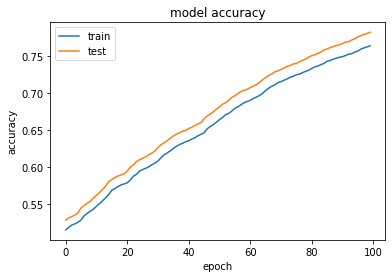

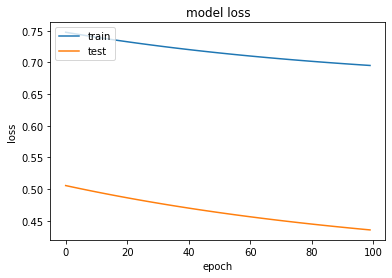

In [33]:
# FM 特征组合层
class crossLayer(layers.Layer):
    def __init__(self,input_dim, output_dim=10, **kwargs):
        super(crossLayer, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        # 定义交叉特征的权重
        self.kernel = self.add_weight(name='kernel', 
                                     shape=(self.input_dim, self.output_dim),
                                     initializer='glorot_uniform',
                                     trainable=True)
        
    def call(self, x): # 对照上述公式中的二次项优化公式一起理解
        a = K.pow(K.dot(x, self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return 0.5 * K.mean(a-b, 1, keepdims=True)

# 定义FM模型
def FM(feature_dim):
    inputs = Input(shape=(feature_dim, ))
    
    # 一阶特征
    linear = Dense(units=1, 
                   kernel_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01))(inputs)
    
    # 二阶特征
    cross = crossLayer(feature_dim)(inputs)
    add = Add()([linear, cross])  # 将一阶特征与二阶特征相加构建FM模型
    
    pred = Activation('sigmoid')(add)
    model = Model(inputs=inputs, outputs=pred)
    
    model.summary()   
    model.compile(loss='MeanSquaredError',
                  optimizer=optimizers.SGD(),
                  metrics=['accuracy'])
    
    return model    


x_trn = features_matrix
y_trn = ratings_train.flatten()
y_tst = ratings_test.flatten()



# 定义模型
model = FM(x_trn.shape[1])

# 训练模型
history = model.fit(x_trn, y_trn, epochs=100, batch_size=87000, validation_data=(x_trn, y_tst), verbose = 0)
result(history)


In [36]:
history.params

{'epochs': 100, 'steps': 1, 'verbose': 0}

In [37]:
train_accuracy_Naive = history.history['accuracy'][-1]
train_loss_Naive = history.history['loss'][-1]
test_accuracy_Naive = history.history['val_accuracy'][-1]
test_loss_Naive = history.history['val_loss'][-1]

print("train_accuracy_Naive: ", train_accuracy_Naive)
print("train_loss_Naive: ", train_loss_Naive)
print("test_accuracy_Naive: ", test_accuracy_Naive)
print("test_loss_Naive: ", test_loss_Naive)

train_accuracy_Naive:  0.7643448114395142
train_loss_Naive:  0.6952614188194275
test_accuracy_Naive:  0.7827011346817017
test_loss_Naive:  0.43568041920661926


In [41]:
predicted_r_1d = model.predict(features_matrix).reshape(87000,)
predicted_r = predicted_r_1d.reshape(290,300)

In [42]:
predicted_r

array([[0.7617983 , 0.45984998, 0.43280342, ..., 0.38472378, 0.50381976,
        0.3900962 ],
       [0.703751  , 0.39183846, 0.36009496, ..., 0.33343595, 0.44327998,
        0.33579135],
       [0.62986153, 0.3280129 , 0.29467827, ..., 0.27145326, 0.3658214 ,
        0.27455893],
       ...,
       [0.6729376 , 0.36187577, 0.33070287, ..., 0.31124344, 0.41445783,
        0.31691077],
       [0.5374028 , 0.24769953, 0.22043552, ..., 0.20527956, 0.2832669 ,
        0.20724525],
       [0.5374028 , 0.24769953, 0.22043552, ..., 0.20527956, 0.2832669 ,
        0.20724525]], dtype=float32)

In [45]:
# train
u = (predicted_r*5 - observed_r)**2
u = u.flatten()
v = abs(predicted_r*5 - observed_r)
v = v.flatten()
MSE_train_Naive = sum(u[~np.isnan(u)])/observed_r_1d.shape[0]
MAE_train_Naive = sum(v[~np.isnan(u)])/observed_r_1d.shape[0]
print("MAE_train_Naive: ", MAE_train_Naive)
print("MSE_train_Naive: ", MSE_train_Naive)

MAE_train_Naive:  1.286640458738153
MSE_train_Naive:  2.5171771381352093


In [46]:
# test
u = (predicted_r*5 - ratings_test)**2
u = u.flatten()
v = abs(predicted_r*5 - ratings_test)
v = v.flatten()
MSE_test_Naive = sum(u[~np.isnan(u)])/u.shape[0]
MAE_test_Naive = sum(v[~np.isnan(u)])/v.shape[0]
print("MAE_test_Naive: ", MAE_test_Naive)
print("MSE_test_Naive: ", MSE_test_Naive)

MAE_test_Naive:  1.8334628522272767
MSE_test_Naive:  3.815248794808217


## Things to do
1. lr of imputation

2. max_iter of imputation

3. FM epochs

4. Yahoo

5. MAE MSE DCG 

6. Compare Naive FM without impuation error and IPS




(array([ 1967., 10379., 17963., 17620., 16852., 11875.,  6438.,  2741.,
          947.,   218.]),
 array([0.4359229, 0.8076049, 1.179287 , 1.550969 , 1.922651 , 2.2943332,
        2.6660151, 3.0376973, 3.4093792, 3.7810614, 4.1527433],
       dtype=float32),
 <a list of 10 Patch objects>)

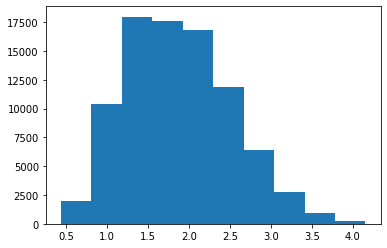

In [47]:
counts, bins = np.histogram(predicted_r*5)
plt.hist(bins[:-1], bins, weights=counts)